In [1]:
import json
from pprint import PrettyPrinter

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

from gym_agents.envs import create_env
from gym_agents.agents import DQNAgent

Using TensorFlow backend.


In [2]:
printer = PrettyPrinter(indent=2)

In [3]:
agent_id = 'DQNAgent'
env_id = 'CustomMountainCar-v0'
independent_variable = 'epsilon_decay'

In [4]:
def make_plot(x, y=None, xlabel=None, ylabel=None, title=None):
    if y:
        plt.plot(x, y)
    else:
        plt.plot(x)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.show()

In [5]:
def generate_policy_report(env_id, model_file_path):
    print('Policy the agent uses when playing')
    env = create_env(env_id)
    agent = DQNAgent(env.action_space, env.observation_space)
    agent.load(model_file_path)
    
    X = np.random.uniform(-1.2, 0.6, 10000)
    Y = np.random.uniform(-0.07, 0.07, 10000)
    Z = []
    
    for i in range(len(X)):
        arr = np.array(([[X[i], Y[i]]]))
        action = agent.act_model(arr, None, None)
        Z.append(action)
    Z = pd.Series(Z)
    colors_ = {0:'blue',1:'lime',2:'red'}
    colors = Z.apply(lambda x:colors_[x])
    labels = ['Left','Right','Nothing']
    
    fig = plt.figure(3, figsize=[7,7])
    ax = fig.gca()
    plt.set_cmap('brg')
    surf = ax.scatter(X,Y, c=Z)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_title('Policy')
    recs = []
    for i in range(0,3):
         recs.append(
             mpatches.Rectangle(
                 (0,0),
                 1,1,
                 fc=sorted(colors.unique())[i]
             )
         )
    plt.legend(recs,labels,loc=4,ncol=3)
    fig.savefig(f'{model_file_path}-policy.png')
    plt.axvline(0.5)
    plt.show()

In [6]:
def generate_game_report(env_id, model_filepath):
    print('Report for a single game, using the trained agent:')
    env = create_env(env_id)
    agent = DQNAgent(env.action_space, env.observation_space)
    agent.load(model_filepath)
    
    positions, velocities, actions = [], [], []
    
    state = env.reset()
    state = np.reshape(state, [1, 2])
    done = False
    while not done:

        pos = state[0][0]
        vel = state[0][1]
        positions.append(pos)
        velocities.append(vel)

        action = agent.act_model(state, None, None)

        actions.append(action)

        state, reward, done, _ = env.step(action)
        state = np.reshape(state, [1, 2])
    
    make_plot(positions, xlabel='Step Number', 
              ylabel='Cart Position', title='Cart Position over Time')
    make_plot(velocities, xlabel='Step Number', 
              ylabel='Cart Velocity', title='Cart Velocity over Time')

    fig = plt.figure(3, figsize=[7, 7])
    ax = fig.gca()
    ax.scatter(positions, velocities)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_title('Position vs Velocity')
    plt.show()

In [7]:
def generate_report(agent_id, env_id, iv, iteration):
    
    json_filename = f'{env_id}-{agent_id}-{iv}-{iteration}.json'
    model_filename = f'models/{env_id}-{agent_id}-{iv}-{iteration}.model'
    
    try:
        with open(json_filename) as fh:
            data = json.load(fh)
    except FileNotFoundError as e:
        print(f'Did not find `{filename}`. Run `python -m gym_agents` first.')
        
    initial_agent_config = data['agent_config']['initial']
    final_agent_config = data['agent_config']['final']

    print(f'Report for the Independent Variable:{iv}')
    
    print('Initial agent config:')
    printer.pprint(initial_agent_config)
    print('Final agent config:')
    printer.pprint(final_agent_config)
    
    print('Train Episode Plots:')
    
    train_episode_reward_history = data['data']['train_episode_rewards']
    train_episode_steps_history = data['data']['train_episode_steps']
    make_plot(train_episode_reward_history, xlabel='Episode Number', 
              ylabel='Train Episode Reward', title='Train Episode vs Reward')
    make_plot(train_episode_steps_history, xlabel='Episode Number', 
              ylabel='Train Episode Steps', title='Train Episode vs Number of Steps')
    
    print('Test Episode Plots:')
    test_episode_reward_history = data['data_test']['test_episode_rewards']
    test_episode_steps_history = data['data_test']['test_episode_steps']
    make_plot(test_episode_reward_history, xlabel='Episode Number', 
              ylabel='Test Episode Reward', title='Test Episode vs Reward')
    make_plot(test_episode_steps_history, xlabel='Episode Number', 
              ylabel='Test Episode Steps', title='Test Episode vs Number of Steps')
    
    print('Agent & Model During Training:')
    epsilon_history = data['data']['train_episode_epsilons']
    loss_history = data['agent_history']['loss']
    make_plot(epsilon_history, xlabel='Episode Number', 
              ylabel='Epsilon', title='Train Episode vs (final) Episode Epsilon')
    make_plot(loss_history, xlabel='Model Fit Call', 
              ylabel='Loss Rate', title='Model Fit Call vs Loss Rate')

    save_freq = data['runner_config']['save_freq']
    saved_mean = data['runner_config']['saved_mean']
    saved_means = data['runner_config']['saved_means']
    
    print('Saved Mean over time:')
    x = []
    y = []
    for mean in saved_means:
        x.append(mean['episode_num'])
        y.append(mean[f'{save_freq}_episode_mean'])
    make_plot(x, y, 'Episode Number', f'Last {save_freq} Episode Mean')

    generate_game_report(env_id, model_filename)
    generate_policy_report(env_id, model_filename)
    
    print(f'The saved model had a mean reward of: {saved_mean}')

Report for the Independent Variable:epsilon_decay
Initial agent config:
{ 'epsilon': 1.0,
  'epsilon_decay': 0.99,
  'epsilon_min': 0.01,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'num_layers': 1}
Final agent config:
{ 'epsilon': 0.009920974201040588,
  'epsilon_decay': 0.99,
  'epsilon_min': 0.01,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'num_layers': 1}
Train Episode Plots:


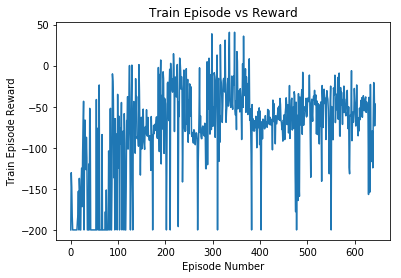

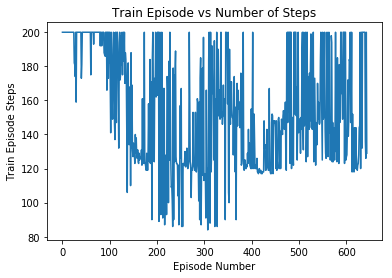

Test Episode Plots:


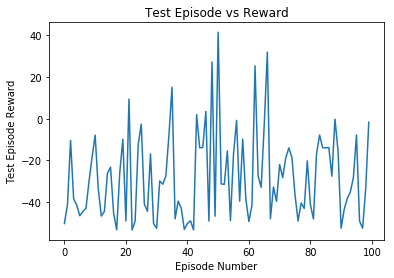

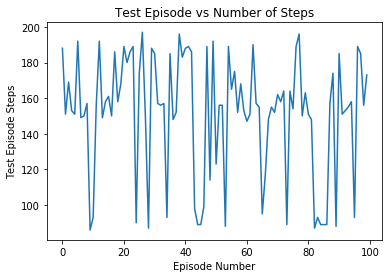

Agent & Model During Training:


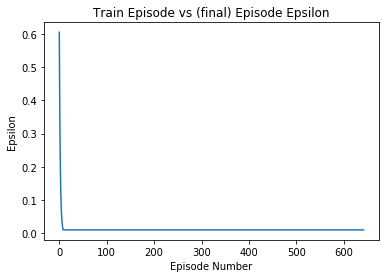

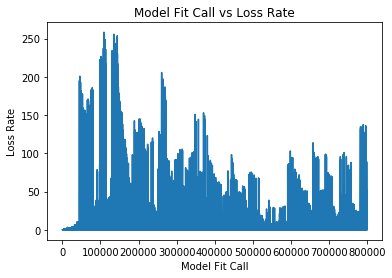

Saved Mean over time:


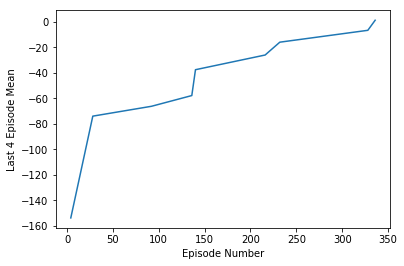

Report for a single game, using the trained agent:


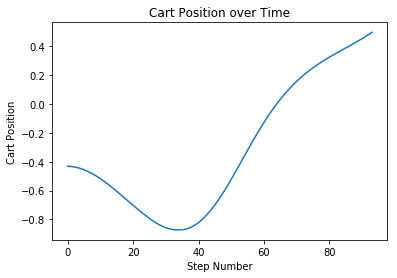

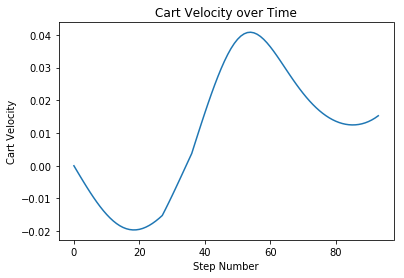

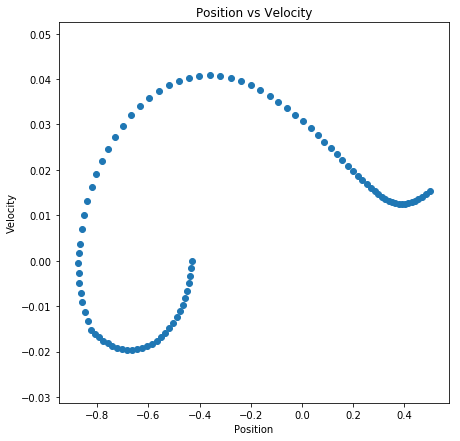

Policy the agent uses when playing


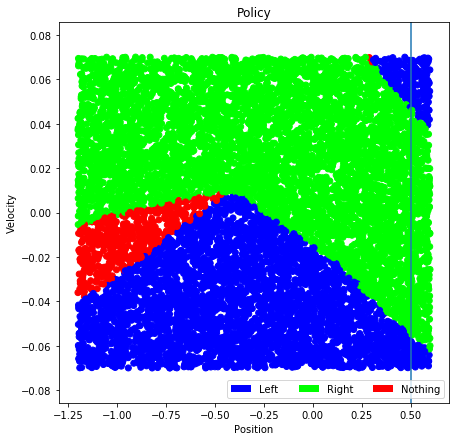

The saved model had a mean reward of: 1.3769643326665768


In [8]:
generate_report(agent_id, env_id, independent_variable, 0)

Report for the Independent Variable:epsilon_decay
Initial agent config:
{ 'epsilon': 1.0,
  'epsilon_decay': 0.999,
  'epsilon_min': 0.01,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'num_layers': 1}
Final agent config:
{ 'epsilon': 0.009998671593271896,
  'epsilon_decay': 0.999,
  'epsilon_min': 0.01,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'num_layers': 1}
Train Episode Plots:


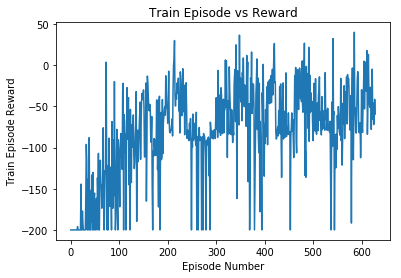

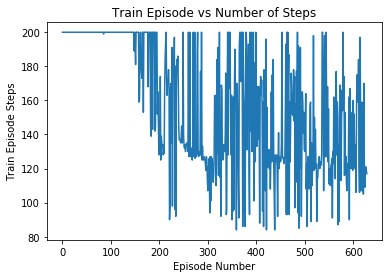

Test Episode Plots:


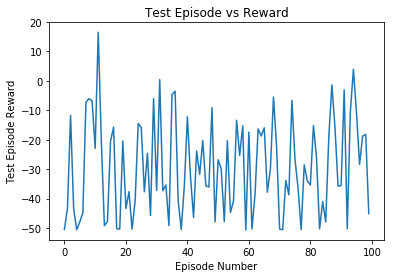

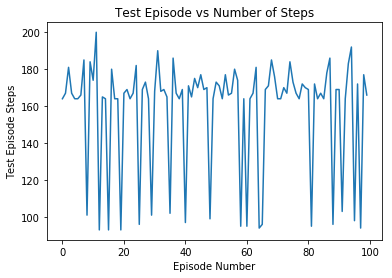

Agent & Model During Training:


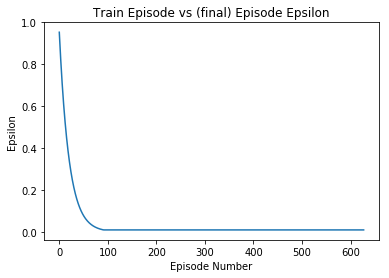

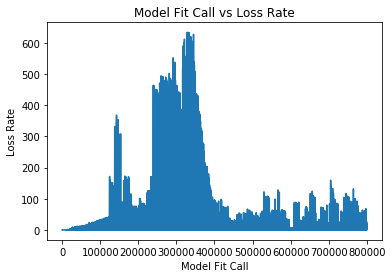

Saved Mean over time:


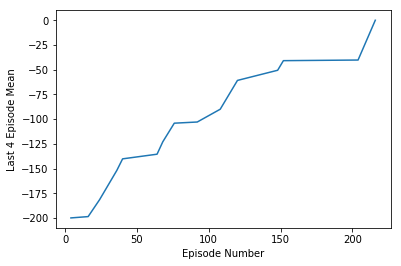

Report for a single game, using the trained agent:


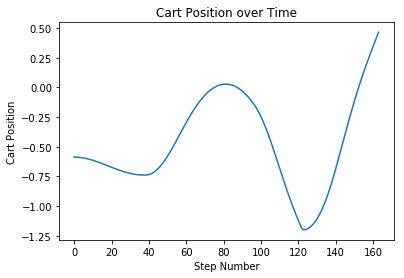

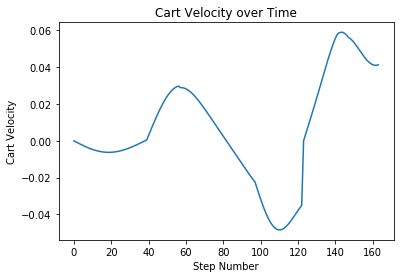

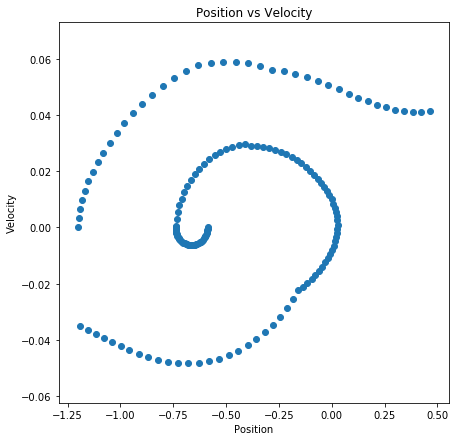

Policy the agent uses when playing


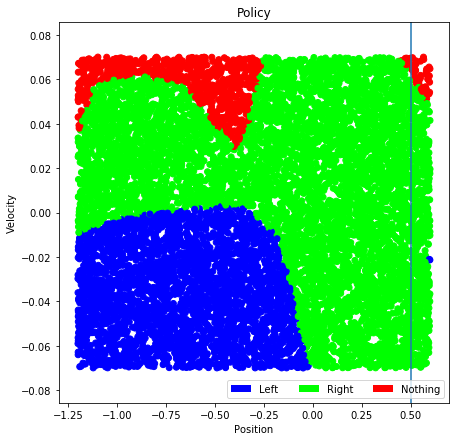

The saved model had a mean reward of: 0.15752226614555553


In [9]:
generate_report(agent_id, env_id, independent_variable, 1)

Report for the Independent Variable:epsilon_decay
Initial agent config:
{ 'epsilon': 1.0,
  'epsilon_decay': 0.9999,
  'epsilon_min': 0.01,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'num_layers': 1}
Final agent config:
{ 'epsilon': 0.08207473795634762,
  'epsilon_decay': 0.9999,
  'epsilon_min': 0.01,
  'gamma': 0.95,
  'learning_rate': 0.001,
  'num_layers': 1}
Train Episode Plots:


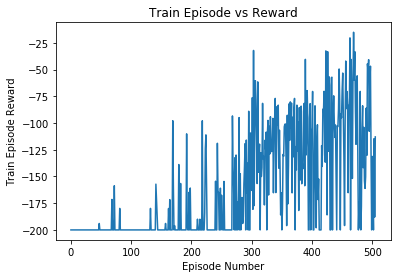

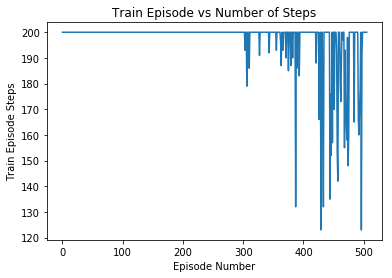

Test Episode Plots:


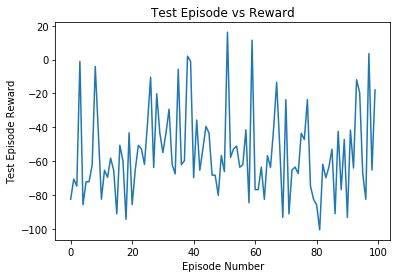

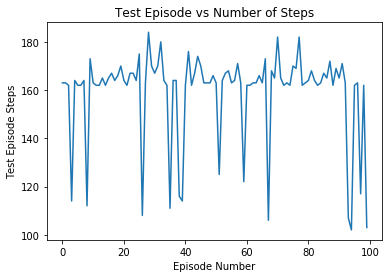

Agent & Model During Training:


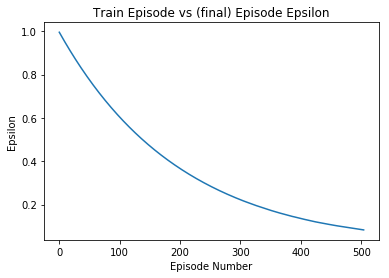

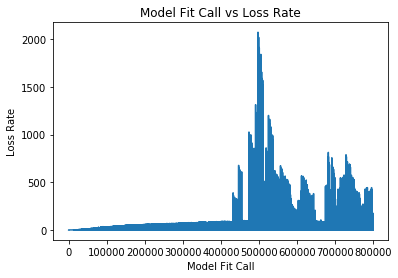

Saved Mean over time:


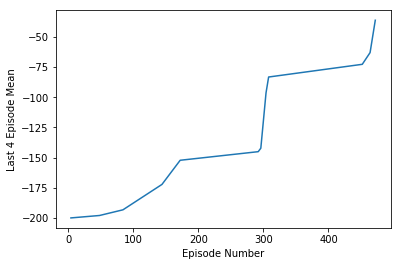

Report for a single game, using the trained agent:


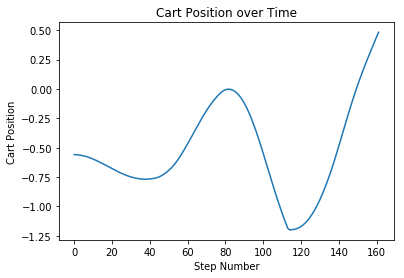

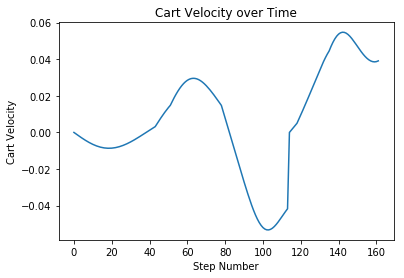

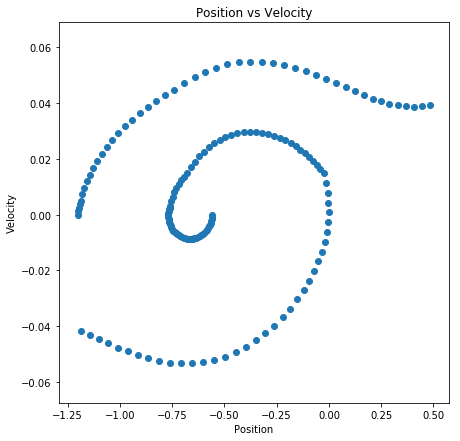

Policy the agent uses when playing


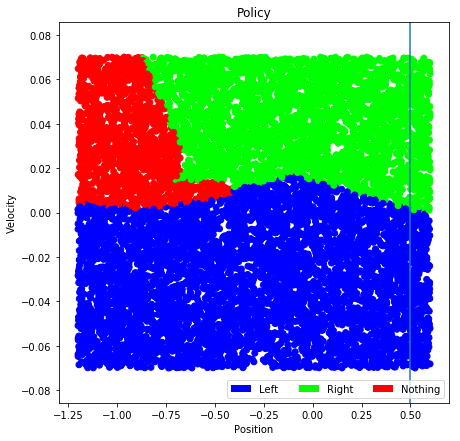

The saved model had a mean reward of: -36.1836881326359


In [10]:
generate_report(agent_id, env_id, independent_variable, 2)